## Image segmentation verification
This notebook demonstrates the background removal in data pipeline made (data_segmentation.py) used during dataset preparation for training a ResNet-based models in the Hair Type Classifier project.

A BiSeNet-based face parsing model (https://yakhyo.github.io/face-parsing/) is used to segment and remove non-hair regions.

This model also generalizes well to images without the face is partially or not visible.

In [1]:
import sys
import yaml
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os

### 1. Paths and config load

In [2]:
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

CONFIG_PATH = project_root / "config" / "config.yaml"
if not CONFIG_PATH.exists():
    raise FileNotFoundError(f"Config file not found: {CONFIG_PATH}")

with open(CONFIG_PATH, "r") as f:
    CONFIG = yaml.safe_load(f)

RAW_DIR = project_root / CONFIG['dataset']['raw_input_dir']
MASK_DIR = project_root / CONFIG['dataset']['mask_dir']

print(f"RAW dir: dataset/{RAW_DIR.name}")
print(f"MASK dir: dataset/{MASK_DIR.name}")

RAW dir: dataset/raw
MASK dir: dataset/masks


In [3]:
def visualize_single_pair(ax_orig, ax_mask, img_orig, masked_img):
    
    # original img
    ax_orig.imshow(img_orig)
    ax_orig.set_title(f"Original", fontsize=8)
    ax_orig.axis('off')

    # masked img
    ax_mask.imshow(masked_img)
    ax_mask.set_title(f"Masked", fontsize=8)
    ax_mask.axis('off')


def get_masked_image(raw_path: Path, mask_path: Path):
    try:
        img_orig = Image.open(raw_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        black_bg = Image.new("RGB", img_orig.size, (0, 0, 0))
        masked_img = Image.composite(img_orig, black_bg, mask)
        
        return img_orig, masked_img
    except Exception as e:
        # print(f"Error processing {raw_path.name}: {e}")
        return None, None


### 3. iteration and visualization logic

In [4]:
def visualize_dataset_sample(raw_base_dir: Path, mask_base_dir: Path):
    all_samples = []

    for class_folder in sorted(raw_base_dir.iterdir()):
        if not class_folder.is_dir(): continue

        for subclass_folder in sorted(class_folder.iterdir()):
            if not subclass_folder.is_dir(): continue
            
            subclass_name = subclass_folder.relative_to(raw_base_dir)
            raw_files = [f for f in subclass_folder.iterdir() if f.is_file() and f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.webp']]
            
            if raw_files:
                selected_sample = random.choice(raw_files)
                all_samples.append((selected_sample, subclass_name))


    print(f"Visualization of samples from subclasses")
    
    fig, axes = plt.subplots(3, 6, figsize=(20, 10))
    
    for i in range(len(all_samples)):
        if i >= 9: break
        
        raw_path, subclass_name = all_samples[i]
        mask_path = mask_base_dir / subclass_name / (raw_path.stem + ".png")
        
        row = i // 3
        col_orig = (i % 3) * 2
        col_mask = col_orig + 1
        
        try:
            img_orig, masked_img = get_masked_image(raw_path, mask_path)
            
            # original
            if img_orig is not None:
                axes[row, col_orig].imshow(img_orig)
                axes[row, col_orig].set_title(f"{subclass_name.name}\nOriginal", fontsize=9)
            
            # masked
            if masked_img is not None:
                axes[row, col_mask].imshow(masked_img)
                axes[row, col_mask].set_title(f"Mask", fontsize=9)
                
        except Exception as e:
            print(f"Error {e}")


    for ax in axes.flatten():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### 4. Visualisation

Visualization of samples from subclasses


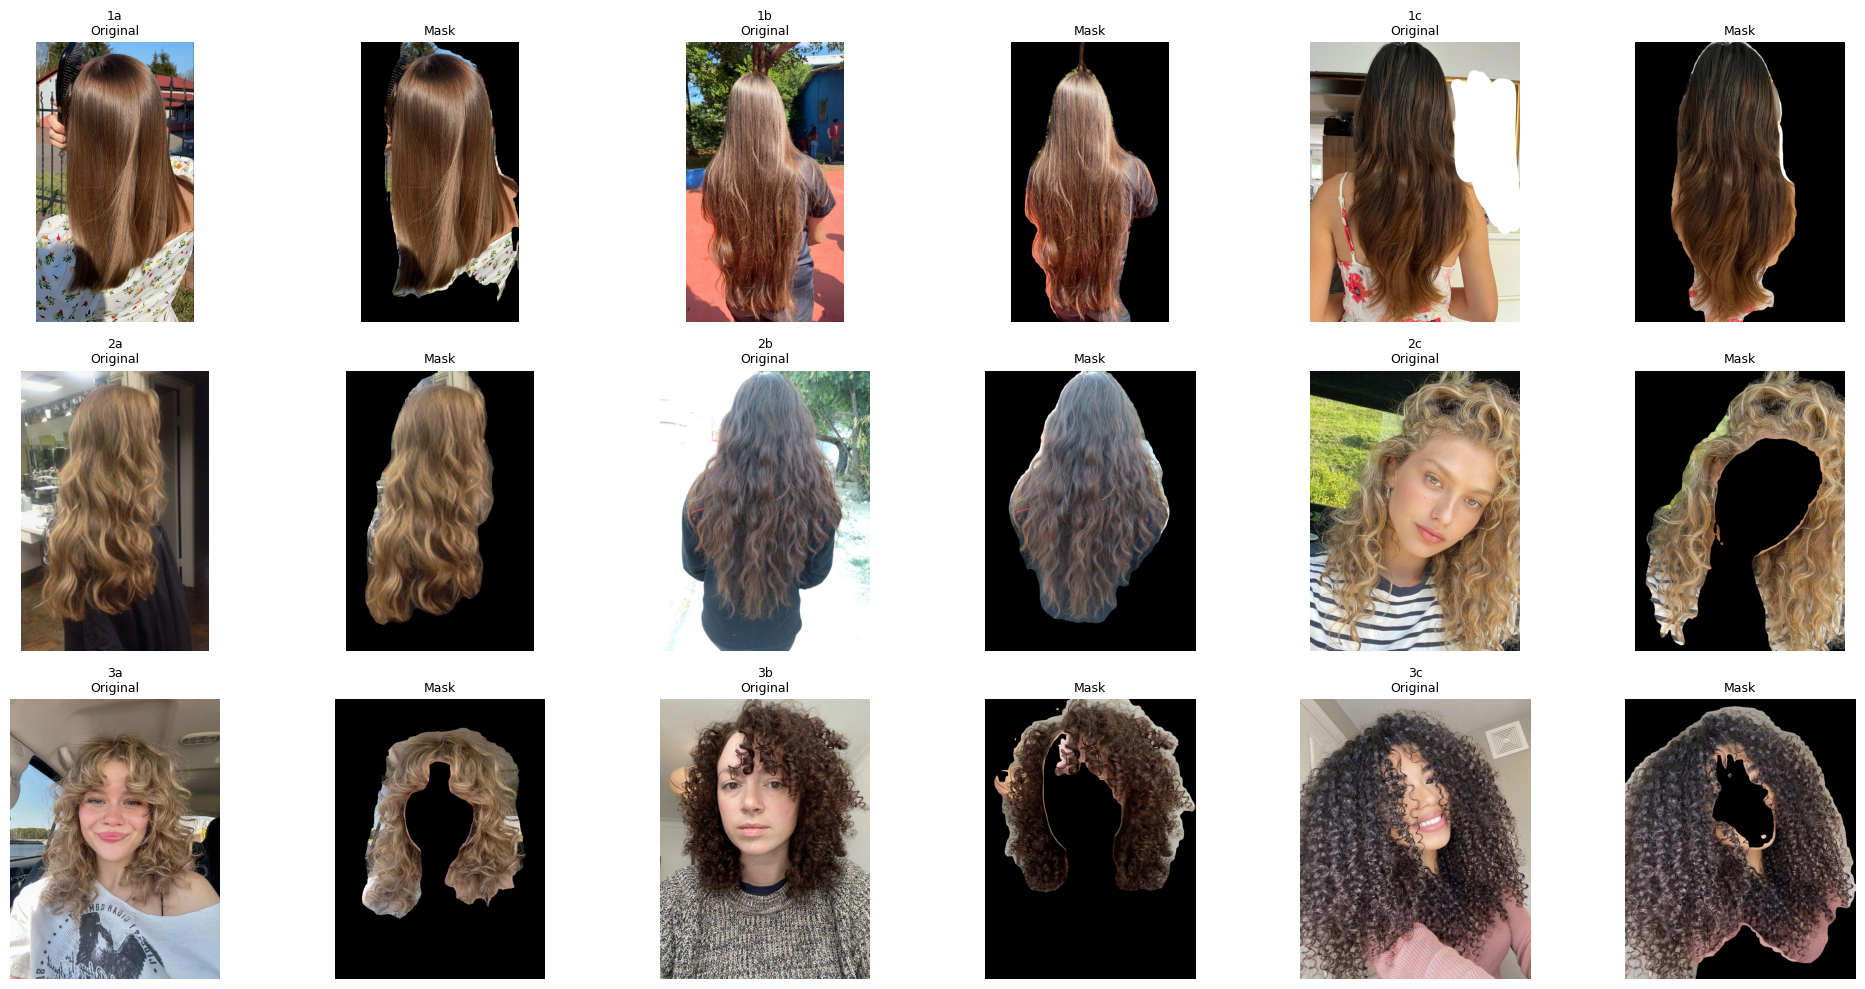

In [5]:
%matplotlib inline 

visualize_dataset_sample(RAW_DIR, MASK_DIR)